https://www.computerworld.com/article/3038270/create-maps-in-r-in-10-fairly-easy-steps.html


Each county has a FIPS code as shown in 
https://www.mcc.co.mercer.pa.us/dps/state_fips_code_listing.htm

This tutorial is adapted from part of Computerworld's How to Make a Map with R in 10 (fairly) Easy Steps https://www.computerworld.com/article/3038270/data-analytics/create-maps-in-r-in-10-fairly-easy-steps.html
 by Sharon Machlis sharon_machlis@idg.com
 
 The purpose of it is to show the outcome during the US presidential campaign of 2016, of 
 
  - the New Hampshire primary results for the Democratic Party 
  - the South Carolina primary results for the Republican Party.
 
 Please note that some of the code needed to be updated because tmaptools is no longer in use.

In [1]:

# Run any of the install.packages() commands below for packages that are not yet on your system
#  install.packages("shiny") 
#  install.packages("urltools")
#  install.packages("tmap")
#  install.packages("leaflet")
#  install.packages("leaflet.extras")
#  install.packages("rio")
#  install.packages("scales")
#  install.packages("htmlwidgets")
#  install.packages("sf")
#  install.packages("dplyr")
library(raster)
library(rgdal)
library(ggplot2)
library(broom)
library(RColorBrewer)
library(dplyr)
library(ggsn)
# set factors to false
options(stringsAsFactors = FALSE)
library("tmap")
library("scales")
library("leaflet")
library("sf")
library("leaflet.extras")
library("stringr")

Loading required package: sp

Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-28, (SVN revision 1158)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.2.3, released 2021/04/27
Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/4.1-arm64/Resources/library/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 7.2.1, January 1st, 2021, [PJ_VERSION: 721]
Path to PROJ shared files: /Library/Frameworks/R.framework/Versions/4.1-arm64/Resources/library/rgdal/proj
PROJ CDN enabled: FALSE
Linking to sp version:1.4-6
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading sp or rgdal.
Overwritten PROJ_LIB was /Library/Frameworks/R.framework/Versions/4.1-arm64/Resources/library/rgdal/proj


Attaching package:

In [4]:
# Set various values needed, including names of files and FIPS codes for New Hampshire and South Carolina
nhdatafilecsv <- "NHD2016.csv"
scdatafile <- "SCGOP2016.csv"

usshapefile <- "./Map/usshapefile"
scfipscode <- "45" #South Carolina FIPS code
nhfipscode <- "33"


In [5]:

# Read in the 2016 Presidential Primary - Democratic President New Hampshire election results file:
nhdata <- rio::import(nhdatafilecsv)

# Eliminate columns for minor candidates and just use County, Clinton and Sanders columns:
nhdata <- nhdata[,c("County", "Clinton", "Sanders")]

# Add columns for percents and margins:
nhdata$SandersMarginVotes <- nhdata$Sanders - nhdata$Clinton
nhdata$SandersPct <- (nhdata$Sanders) / (nhdata$Sanders + nhdata$Clinton) # Will use formatting later to multiply by a hundred
nhdata$ClintonPct <- (nhdata$Clinton) / (nhdata$Sanders + nhdata$Clinton)
nhdata$SandersMarginPctgPoints <- nhdata$SandersPct - nhdata$ClintonPct
head(nhdata)

County       Clinton Sanders SandersMarginVotes SandersPct ClintonPct
1 Belknap       3495    6005    2510              0.6321053  0.3678947 
2 Carroll       3230    5638    2408              0.6357691  0.3642309 
3 Cheshire      5132   12441    7309              0.7079611  0.2920389 
4 Coos          2013    3639    1626              0.6438429  0.3561571 
5 Grafton       6918   14245    7327              0.6731087  0.3268913 
6 Hillsborough 28147   39245   11098              0.5823392  0.4176608 
  SandersMarginPctgPoints
1 0.2642105              
2 0.2715381              
3 0.4159222              
4 0.2876858              
5 0.3462175              
6 0.1646783

In [4]:
#Check the name of the layers in the shape file

ogrListLayers(dsn=usshapefile)

[1] "cb_2014_us_county_5m"
attr(,"driver")
[1] "ESRI Shapefile"
attr(,"nlayers")
[1] 1

In [5]:
usgeo <-readOGR(usshapefile,layer="cb_2014_us_county_5m") #We only want x and y dimensions.

OGR data source with driver: ESRI Shapefile 
Source: "/Users/patricia.obyrne/Dropbox/TUDublin/pobyrne/contents/VisData2022/R_2022/Map/usshapefile", layer: "cb_2014_us_county_5m"
with 3233 features
It has 9 fields
Integer64 fields read as strings:  ALAND AWATER 


Warning message in readOGR(usshapefile, layer = "cb_2014_us_county_5m"):
“Z-dimension discarded”


You can look at the contents of usgeo, and at specific columns.

To understand the contents of a Spatial Polygons dataframe, look at https://mhallwor.github.io/_pages/basics_SpatialPolygons

usgeo has @data, @polygons, @plotOrder, @bbox and @proj4string components.  usgeo\\$STATEFP is short for usgeo@data\\$STATEFP

str(usgeo)

In [6]:
usgeo$STATEFP
usgeo$NAME

[1] "01" "13" "19" "40" "42" "40" "31" "29" "32" "12" "05" "48" "49" "31"
  [15] "42" "35" "40" "40" "19" "19" "20" "28" "29" "27" "29" "55" "47" "51"
  [29] "48" "48" "48" "55" "04" "12" "20" "21" "46" "41" "41" "35" "26" "06"
  [43] "01" "31" "40" "39" "36" "18" "29" "20" "28" "17" "72" "31" "29" "13"
  [57] "48" "48" "48" "21" "12" "20" "26" "37" "29" "27" "23" "51" "01" "37"
  [71] "37" "38" "36" "27" "29" "28" "72" "72" "19" "19" "28" "46" "29" "48"
  [85] "04" "08" "18" "05" "39" "28" "02" "12" "02" "51" "40" "38" "39" "39"
  [99] "31" "31" "19" "19" "21" "26" "72" "56" "20" "48" "48" "48" "51" "51"
 [113] "72" "12" "18" "20" "02" "39" "37" "30" "28" "31" "02" "13" "51" "55"
 [127] "39" "27" "18" "15" "19" "19" "20" "28" "17" "72" "29" "31" "26" "48"
 [141] "48" "51" "36" "48" "51" "01" "05" "06" "18" "21" "40" "38" "37" "35"
 [155] "27" "06" "18" "05" "55" "31" "31" "35" "26" "19" "19" "27" "27" "72"
 [169] "31" "19" "20" "55" "48" "48" "72" "46" "08" "13" "20" "21" "42" "46"
 [183] "28" "29" "27" "02" "19" "01" "31" "39" "39" "40" "18" "19" "19" "17"
 [197] "26" "18" "27" "26" "55" "18" "18" "72" "48" "51" "51" "48" "48" "46"
 [211] "04" "16" "24" "42" "47" "26" "13" "19" "13" "36" "36" "19" "19" "20"
 [225] "19" "17" "29" "27" "12" "19" "16" "28" "17" "46" "55" "48" "72" "48"
 [239] "38" "48" "48" "48" "48" "48" "27" "46" "28" "31" "51" "18" "72" "38"
 [253] "48" "18" "47" "18" "48" "37" "19" "06" "16" "19" "16" "17" "17" "37"
 [267] "17" "19" "54" "19" "47" "56" "51" "55" "30" "27" "51" "27" "42" "27"
 [281] "27" "29" "42" "47" "16" "20" "20" "13" "31" "41" "48" "18" "42" "29"
 [295] "29" "27" "01" "26" "36" "31" "31" "38" "29" "26" "55" "29" "26" "05"
 [309] "02" "02" "31" "35" "42" "26" "39" "39" "38" "31" "38" "31" "48" "48"
 [323] "38" "19" "21" "46" "46" "46" "46" "42" "48" "46" "46" "45" "46" "53"
 [337] "42" "29" "55" "51" "31" "55" "29" "55" "48" "55" "55" "37" "20" "20"
 [351] "48" "48" "26" "17" "19" "17" "17" "20" "21" "48" "26" "21" "26" "21"
 [365] "26" "26" "21" "27" "26" "17" "17" "17" "21" "48" "40" "48" "19" "19"
 [379] "27" "48" "40" "39" "27" "48" "27" "48" "36" "34" "27" "48" "29" "06"
 [393] "13" "13" "05" "55" "55" "02" "46" "27" "12" "39" "29" "29" "48" "48"
 [407] "48" "48" "53" "13" "13" "13" "51" "37" "29" "51" "51" "51" "20" "06"
 [421] "19" "20" "12" "17" "08" "48" "29" "12" "20" "40" "01" "08" "01" "13"
 [435] "20" "17" "48" "13" "20" "17" "48" "39" "08" "20" "48" "08" "08" "39"
 [449] "17" "39" "48" "48" "21" "48" "13" "19" "17" "12" "13" "39" "13" "39"
 [463] "39" "39" "48" "39" "48" "51" "51" "29" "48" "29" "48" "48" "40" "08"
 [477] "29" "48" "48" "48" "48" "48" "08" "48" "48" "40" "40" "36" "48" "40"
 [491] "48" "36" "40" "48" "40" "48" "40" "01" "01" "05" "29" "51" "54" "31"
 [505] "54" "29" "54" "72" "72" "72" "28" "50" "28" "55" "32" "32" "72" "72"
 [519] "39" "27" "12" "28" "38" "02" "38" "20" "41" "26" "38" "19" "20" "13"
 [533] "26" "19" "18" "26" "47" "20" "72" "26" "51" "72" "60" "18" "20" "02"
 [547] "19" "06" "18" "06" "18" "49" "17" "06" "20" "55" "55" "16" "16" "20"
 [561] "38" "20" "22" "36" "37" "17" "20" "42" "30" "31" "31" "13" "02" "48"
 [575] "31" "31" "42" "39" "40" "18" "19" "20" "20" "19" "28" "17" "29" "18"
 [589] "72" "26" "26" "48" "46" "48" "47" "39" "38" "39" "04" "13" "20" "22"
 [603] "23" "24" "39" "30" "27" "28" "08" "12" "12" "13" "28" "28" "46" "13"
 [617] "72" "27" "28" "17" "21" "44" "26" "08" "01" "54" "31" "29" "39" "26"
 [631] "19" "16" "27" "17" "29" "29" "55" "55" "47" "13" "20" "22" "30" "28"
 [645] "28" "13" "48" "42" "40" "20" "17" "26" "17" "29" "19" "28" "48" "51"
 [659] "40" "27" "27" "26" "55" "18" "31" "60" "20" "55" "48" "48" "48" "48"
 [673] "36" "38" "39" "13" "18" "20" "26" "46" "37" "39" "40" "37" "29" "33"
 [687] "26" "08" "05" "53" "54" "31" "31" "39" "40" "18" "20" "20" "28" "28"
 [701] "29" "21" "72" "31" "18" "19" "29" "46" "46" "55" "51" "51" "38" "01"
 [715] "04" "06" "06" "02" "02" "05" "13" "02" "01" "48" "37" "39" "38" "39"

[1] "Franklin"              "Fannin"                "Kossuth"              
   [4] "Ottawa"                "Susquehanna"           "Grant"                
   [7] "Chase"                 "Taney"                 "Carson City"          
  [10] "Hardee"                "Cleburne"              "Bailey"               
  [13] "San Juan"              "Polk"                  "Lebanon"              
  [16] "Los Alamos"            "Stephens"              "Lincoln"              
  [19] "Cedar"                 "Franklin"              "Pratt"                
  [22] "Neshoba"               "Polk"                  "Murray"               
  [25] "Macon"                 "Fond du Lac"           "Trousdale"            
  [28] "Manassas"              "Midland"               "Johnson"              
  [31] "Gillespie"             "Waushara"              "Mohave"               
  [34] "Charlotte"             "Decatur"               "Cumberland"           
  [37] "Miner"                 "Josephine"             "Curry"                
  [40] "Cibola"                "Alcona"                "Trinity"              
  [43] "Morgan"                "Seward"                "Woodward"             
  [46] "Hancock"               "Montgomery"            "Rush"                 
  [49] "Montgomery"            "Kiowa"                 "Prentiss"             
  [52] "Washington"            "Can\xf3vanas"          "Thomas"               
  [55] "Bollinger"             "Heard"                 "Collin"               
  [58] "Crosby"                "Coke"                  "Monroe"               
  [61] "Baker"                 "Jewell"                "Bay"                  
  [64] "Richmond"              "Butler"                "Nobles"               
  [67] "Androscoggin"          "Poquoson"              "Butler"               
  [70] "Alexander"             "Durham"                "Eddy"                 
  [73] "Schenectady"           "Le Sueur"              "Crawford"             
  [76] "Panola"                "Maricao"               "Juana D\xedaz"        
  [79] "Carroll"               "Grundy"                "Stone"                
  [82] "Aurora"                "Ralls"                 "Stonewall"            
  [85] "Coconino"              "Moffat"                "St. Joseph"           
  [88] "Monroe"                "Darke"                 "Alcorn"               
  [91] "Hoonah-Angoon"         "Lafayette"             "Yukon-Koyukuk"        
  [94] "Danville"              "Hughes"                "Logan"                
  [97] "Huron"                 "Champaign"             "Dodge"                
 [100] "Johnson"               "Shelby"                "Wright"               
 [103] "Edmonson"              "Gratiot"               "Comer\xedo"           
 [106] "Natrona"               "Rooks"                 "Floyd"                
 [109] "Howard"                "Mason"                 "Fairfax"              
 [112] "Buena Vista"           "R\xedo Grande"         "Palm Beach"           
 [115] "Warren"                "Stanton"               "Nome"                 
 [118] "Lake"                  "Vance"                 "Sanders"              
 [121] "George"                "Harlan"                "Kenai Peninsula"      
 [124] "Atkinson"              "Greensville"           "Lafayette"            
 [127] "Noble"                 "Hubbard"               "Martin"               
 [130] "Maui"                  "Calhoun"               "Webster"              
 [133] "Grant"                 "Smith"                 "Bond"                 
 [136] "Yauco"                 "Dallas"                "Wheeler"              
 [139] "Jackson"               "King"                  "Wise"                 
 [142] "Lexington"             "Chemung"               "Lamb"                 
 [145] "Staunton"              "Baldwin"               "Polk"                 
 [148] "San Luis Obispo"       "Franklin"              "Pendleton"            
 [151] "Roger Mills"           "Cass"                

We can draw a 'quick thematic map' of the US, with qtm

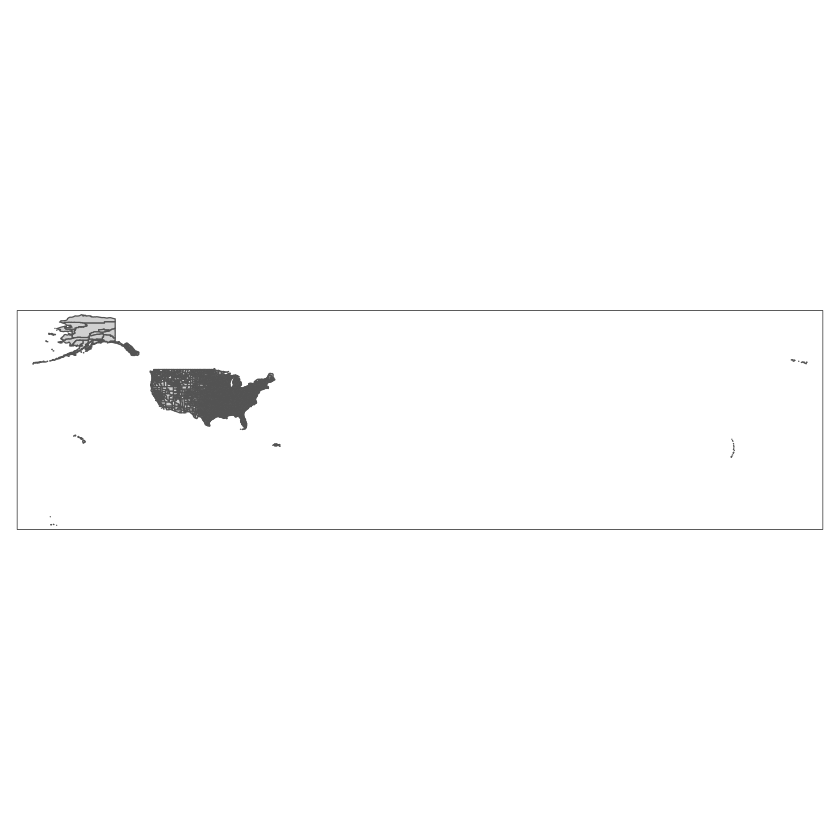

In [7]:
qtm(usgeo)

In [8]:
# Subset the US shapefile to get just New Hampshire data in nhgeo
nhgeo <- usgeo[usgeo$STATEFP==nhfipscode,]
#nhgeo is a full spatial polygon dataframe, but here we just want to see the data part
str(nhgeo@data)

'data.frame':	10 obs. of  9 variables:
 $ STATEFP : chr  "33" "33" "33" "33" ...
 $ COUNTYFP: chr  "009" "011" "007" "001" ...
 $ COUNTYNS: chr  "00873178" "00873179" "00873177" "00873174" ...
 $ AFFGEOID: chr  "0500000US33009" "0500000US33011" "0500000US33007" "0500000US33001" ...
 $ GEOID   : chr  "33009" "33011" "33007" "33001" ...
 $ NAME    : chr  "Grafton" "Hillsborough" "Coos" "Belknap" ...
 $ LSAD    : chr  "06" "06" "06" "06" ...
 $ ALAND   : chr  "4425927252" "2269220216" "4648216798" "1036582289" ...
 $ AWATER  : chr  "105375486" "41604851" "90773891" "177039345" ...


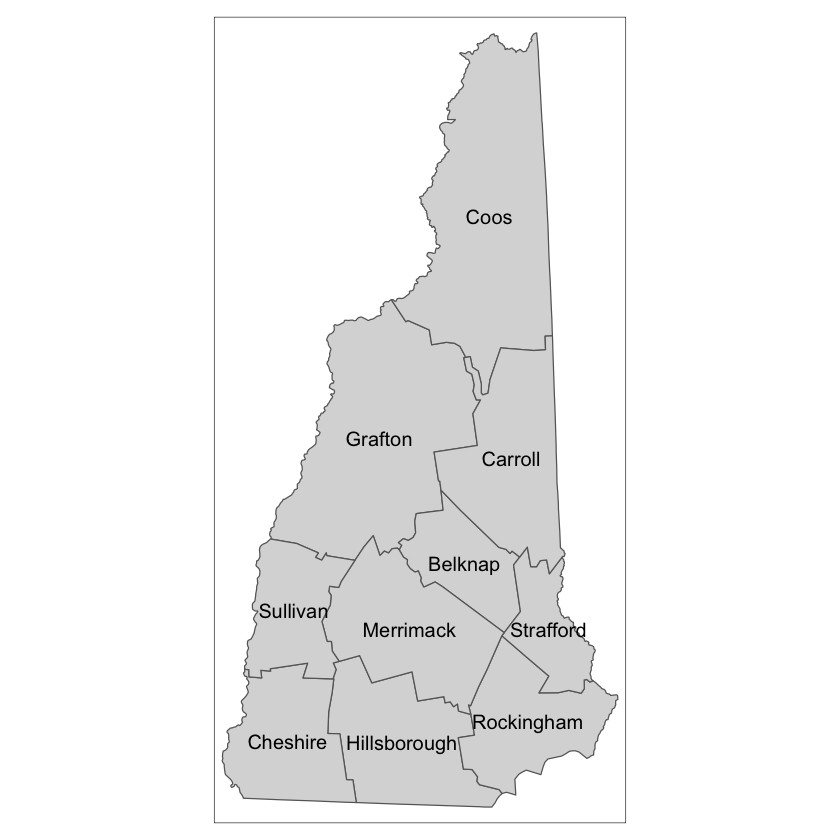

In [9]:
qtm(nhgeo,  text="NAME")

Next, we want to fill the map, depending on the election results in each county.  nhgeo calls the county NAME, whilst nhdata calls it County.

In [10]:
# Make sure county names are in the same format in both files
str(nhgeo$NAME)
str(nhdata$County)

 chr [1:10] "Grafton" "Hillsborough" "Coos" "Belknap" "Rockingham" ...
 chr [1:10] "Belknap" "Carroll" "Cheshire" "Coos" "Grafton" "Hillsborough" ...


In [11]:
# Order each data set by county name
nhgeo <- nhgeo[order(nhgeo$NAME),]
nhdata <- nhdata[order(nhdata$County),]

# Are the two county columns identical now? They should be:
identical(nhgeo$NAME,nhdata$County )

[1] TRUE

# Merging our dataframes

In [12]:
# Merge data to associate the election data (nhdata) with the spatial polygon dataframe
nhmap <- merge(nhgeo, nhdata, by.x="NAME", by.y="County")
# See the new data structure with
str(nhmap)

Formal class 'SpatialPolygonsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	10 obs. of  15 variables:
  .. ..$ NAME                   : chr [1:10] "Belknap" "Carroll" "Cheshire" "Coos" ...
  .. ..$ STATEFP                : chr [1:10] "33" "33" "33" "33" ...
  .. ..$ COUNTYFP               : chr [1:10] "001" "003" "005" "007" ...
  .. ..$ COUNTYNS               : chr [1:10] "00873174" "00873175" "00873176" "00873177" ...
  .. ..$ AFFGEOID               : chr [1:10] "0500000US33001" "0500000US33003" "0500000US33005" "0500000US33007" ...
  .. ..$ GEOID                  : chr [1:10] "33001" "33003" "33005" "33007" ...
  .. ..$ LSAD                   : chr [1:10] "06" "06" "06" "06" ...
  .. ..$ ALAND                  : chr [1:10] "1036582289" "2411458935" "1830366195" "4648216798" ...
  .. ..$ AWATER                 : chr [1:10] "177039345" "158933434" "57990901" "90773891" ...
  .. ..$ Clinton                : int [1:10] 3495 3230 5132 2013 6918 28147 12250 22829 8

In [13]:
str(nhmap@data)

'data.frame':	10 obs. of  15 variables:
 $ NAME                   : chr  "Belknap" "Carroll" "Cheshire" "Coos" ...
 $ STATEFP                : chr  "33" "33" "33" "33" ...
 $ COUNTYFP               : chr  "001" "003" "005" "007" ...
 $ COUNTYNS               : chr  "00873174" "00873175" "00873176" "00873177" ...
 $ AFFGEOID               : chr  "0500000US33001" "0500000US33003" "0500000US33005" "0500000US33007" ...
 $ GEOID                  : chr  "33001" "33003" "33005" "33007" ...
 $ LSAD                   : chr  "06" "06" "06" "06" ...
 $ ALAND                  : chr  "1036582289" "2411458935" "1830366195" "4648216798" ...
 $ AWATER                 : chr  "177039345" "158933434" "57990901" "90773891" ...
 $ Clinton                : int  3495 3230 5132 2013 6918 28147 12250 22829 8813 2497
 $ Sanders                : int  6005 5638 12441 3639 14245 39245 18107 31065 15881 5915
 $ SandersMarginVotes     : int  2510 2408 7309 1626 7327 11098 5857 8236 7068 3418
 $ SandersPct           

##Creating a static map

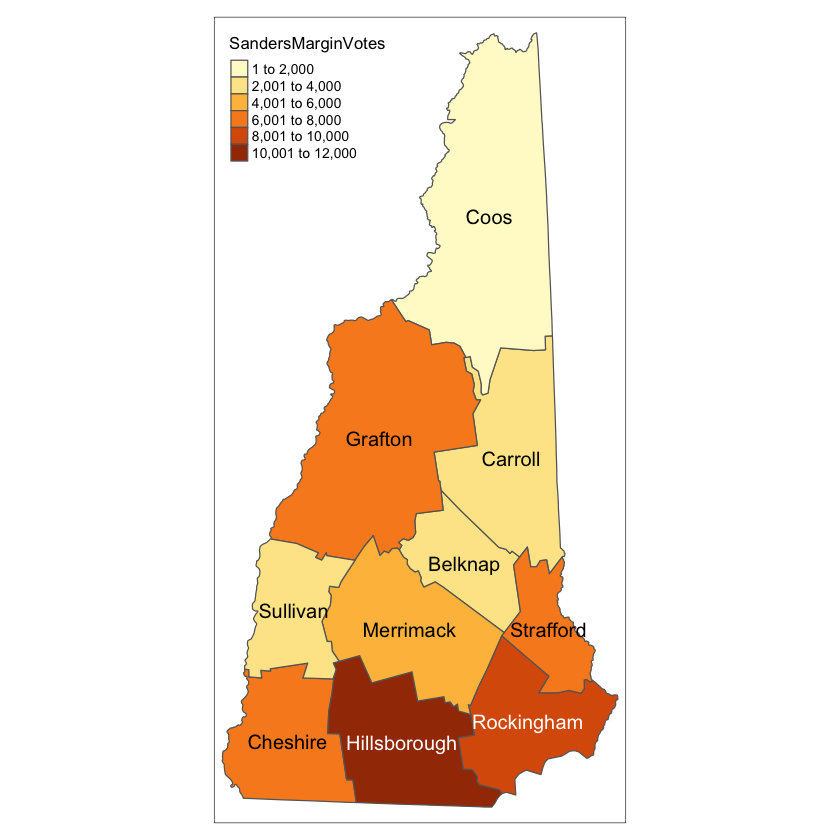

In [14]:
# Quick and easy maps as static images with tmap's qtm() function:
qtm(nhmap, text="NAME", "SandersMarginVotes")

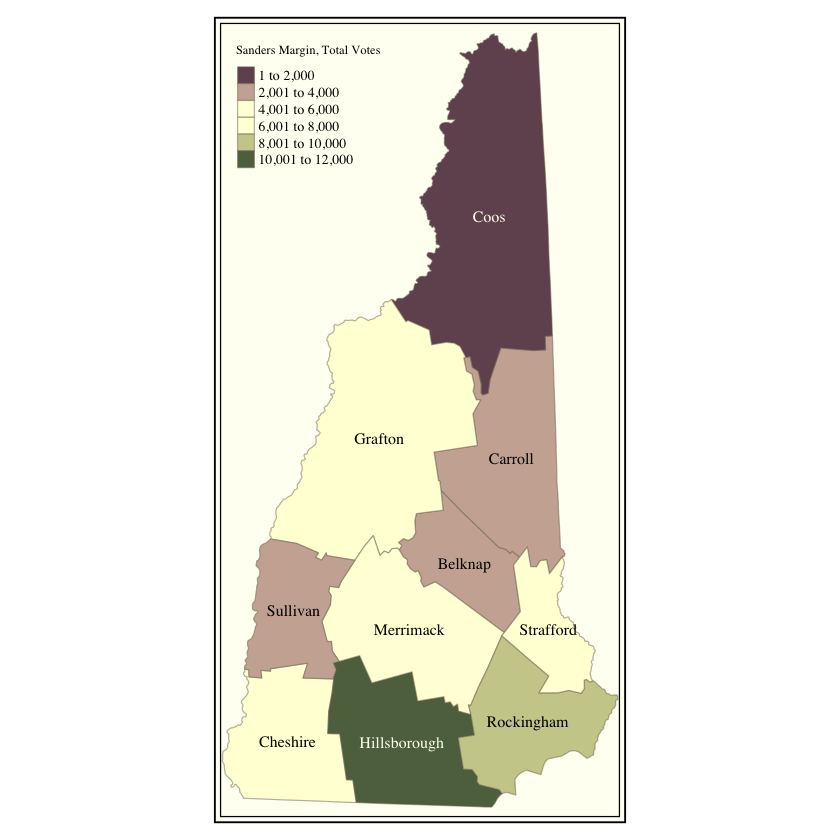

In [15]:
# For more control over look and feel, use the tm_shape() function:
nhstaticmap <-tm_shape(nhmap) +
  tm_fill("SandersMarginVotes", title="Sanders Margin, Total Votes", palette = "PRGn")+
  tm_borders(alpha=.5) +
  tm_text("NAME",size=0.8) +
  tm_style("classic")
nhstaticmap

In [16]:

# save the map to a jpg file:
tmap_save(nhstaticmap, filename="nhdemprimary.jpg")

Map saved to /Users/patricia.obyrne/Dropbox/TUDublin/pobyrne/contents/VisData2022/R_2022/nhdemprimary.jpg

Resolution: 1501.336 by 2937.385 pixels

Size: 5.004452 by 9.791282 inches (300 dpi)



## Creating an interactive map

#### Step 6: Create palette and pop-ups for interactive map
The next map we'll create will let users click to see underlying data as well as switch between maps,using RStudio's Leaflet package that gives an R front-end to the open-source JavaScript Leaflet mapping library.  This uses OpenStreetMap, polygons and longitude and latitude.

For a Leaflet map, there are two extra things we'll want to create in addition to the data we already have: 
 - a color palette and 
 - pop-up window contents.

For palette, we specify the data range we're mapping and what kind of color palette we want — both the particular colors and the type of color scale. 

There are four built-in types:

 - colorNumeric is for a continuous range of colors from low to high, so you might go from a very pale blue all the way to a deep dark blue, with many gradations in between.
 - colorBin maps a set of numerical data to a set of discrete bins, either defined by exact breaks or specific number of bins — things like "low," "medium" and "high".
 - colorQuantile maps numerical data into groups where each group (quantile) has the same number of records — often used for income levels, such as bottom 20%, next-lowest 20% and so on.
 - colorFactor is for non-numerical categories where no numerical value makes sense, such as countries in Europe that are part of the Eurozone and those that aren't.
 
 For more info on mapping with Leaflet, visit https://bookdown.org/nicohahn/making_maps_with_r5/docs/leaflet.html

 

In [17]:
# Next up: Code for a basic interactive map, this time for Clinton percentages in NH

# Create a palette
clintonPalette <- colorNumeric(palette = "Blues", domain=nhmap$ClintonPct)

In [18]:
# and a pop-up window
#library(scales)
nhpopup <- paste0("<b>County: ", 
                  nhmap$NAME, 
                  "</b><br />Sanders ", 
                  percent(nhmap$SandersPct), " - Clinton ", 
                  percent(nhmap$ClintonPct))

For more info on paste0 visit ...https://r-lang.com/paste0-function-in-r-with-example/

The paste() and paste0() functions combine several inputs into a character string.

 ## Basic Usage of Leaflet

You create a Leaflet map with these basic steps:

 - Create a map widget by calling leaflet().
 - Add layers (i.e., features) to the map by using layer functions (e.g. addTiles, addMarkers, addPolygons) to modify the map widget.
 - Repeat step 2 as desired.
 - Print the map widget to display it.

In [19]:
m <- leaflet() %>%
  addTiles() %>%  # Add default OpenStreetMap map tiles
  addMarkers(lng=174.768, lat=-36.852, popup="The birthplace of R")
m  # Print the map

HTML widgets cannot be represented in plain text (need html)

Closer to home...

In [20]:
m <- leaflet() %>%
  addTiles() %>%  # Add default OpenStreetMap map tiles
  addMarkers(lat=53.35723924063129, lng= -6.282026176716366, popup="Grangegorman, Central Quad")

m  # Print the map

HTML widgets cannot be represented in plain text (need html)

We can also use tiles called CartoDB.Positron (or CartoDB.DarkMatter)

In [21]:
m <- leaflet() %>% 
    addProviderTiles("CartoDB.Positron") %>%
  #addTiles() %>%  # Add default OpenStreetMap map tiles
    addMarkers(lat=53.35723924063129, lng= -6.282026176716366, popup="Grangegorman, Central Quad")

m  # Print the map

HTML widgets cannot be represented in plain text (need html)

In [22]:
m <- leaflet() %>% 
    addProviderTiles("CartoDB.DarkMatter") %>%
  #addTiles() %>%  # Add default OpenStreetMap map tiles
    addMarkers(lat=53.35723924063129, lng= -6.282026176716366, popup="Grangegorman, Central Quad")

m  # Print the map

HTML widgets cannot be represented in plain text (need html)

Getting back to New Hampshire, we're enhancing our map, concentrating on the polygons in New Hampshire.  This is done by adding and parameterising the polygons.  See https://search.r-project.org/CRAN/refmans/leaflet/html/map-layers.html for parameters and what they do.

When this map is generated, the user can click on a county and get the data in nhpopup.

In [23]:

# Now the interactive map:
leaflet(nhmap) %>%
  addProviderTiles("CartoDB.Positron") %>%
  addPolygons(stroke=FALSE, #stroke = TRUE adds a heavy border between the polygons.
              smoothFactor = 0.2, 
              fillOpacity = .8, 
              popup=nhpopup, 
              color= ~clintonPalette(nhmap$ClintonPct)
              )
  

HTML widgets cannot be represented in plain text (need html)


You may get an error message about an "inconsistent datum" along with your map. Projections are a complicated issue when mapping, but basically, you want your data projection to match that of your the underlying map tiles. This ensures that everything's consistent in terms of the scheme used to represent points on a 3D sphere in two dimensions. To fix this, you can add the projection recommended in the error message with

nhmap_projected <- sf::st_transform(nhmap, "+proj=longlat +datum=WGS84")


and then run the map code above with

leaflet(nhmap_projected) \%\>\%

In [24]:
# re-project
nhmapsf<-st_as_sf(nhmap)
nhmap_projected <- sf::st_transform(nhmapsf, "+proj=longlat +datum=WGS84")
leaflet(nhmap_projected) %>%
  addProviderTiles("CartoDB.Positron") %>%
  addPolygons(stroke=FALSE, 
              smoothFactor = 0.2, 
              fillOpacity = .8, 
              popup=nhpopup, 
              color= ~clintonPalette(nhmap$ClintonPct)
  )

HTML widgets cannot be represented in plain text (need html)

# South Carolina

This time we'll add layers to the map.  There'll be a layer for 

 - each of the top 3 candidates, with their performance in each county.
 - the winner in each county.
 - the percentage of the elgible voters in each county that have a third-level qualification.
    -  we get this from a different dataset that we'll read in.

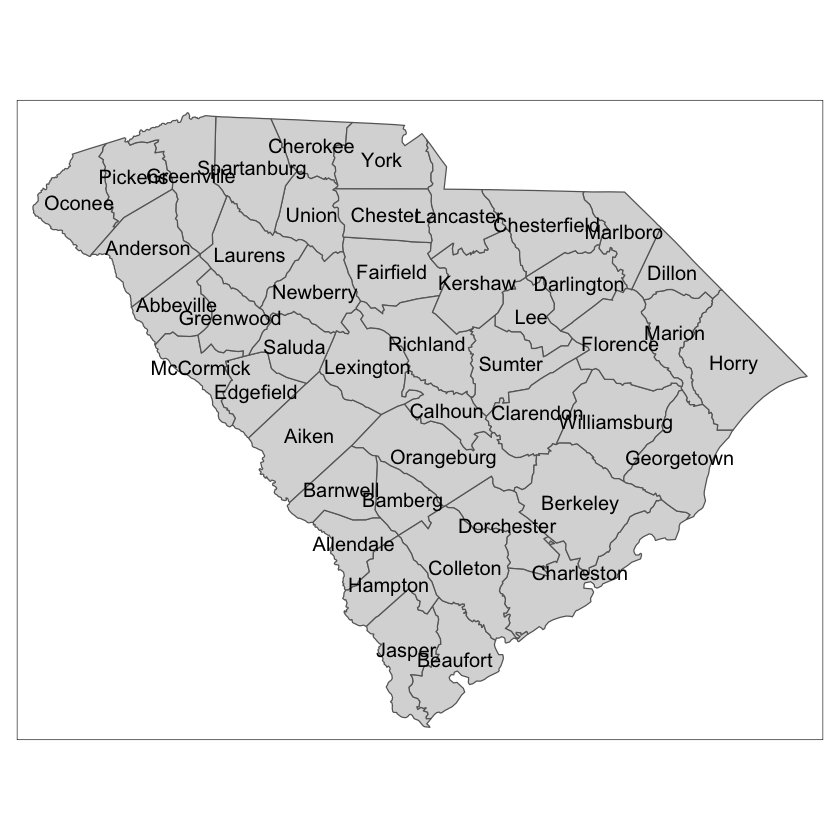

In [25]:
# South Carolina data
scdata <- rio::import(scdatafile)
sfgeo<-st_as_sf(usgeo)
# South Carolina shapefile:
scgeo <- dplyr::filter(sfgeo, STATEFP==scfipscode)

# Quick plot of scgeo SC geospatial object:
qtm(scgeo, text="NAME")

Let's see who the candidates are (remember, there's a column for each one:)

In [26]:
colnames(scdata)

[1] "County"         "Jeb Bush"       "Ben Carson"     "Ted Cruz"      
[5] "John R Kasich"  "Marco Rubio"    "Donald J Trump" "Total"

... and how many counties there are...

In [27]:
length(unique(scdata$County))

[1] 46

In [28]:
# Add a column with percent of votes for each candidate. Candidates are in columns 2-7:
candidates <- colnames(scdata[2:7])
for(i in 2:7){
  j = i + 7
  temp <- scdata[[i]] / scdata$Total
  scdata[[j]] <- temp
  colnames(scdata)[j] <- paste0(colnames(scdata)[i], "Pct")
}  
  
# Get winner in each county
for(i in 1:nrow(scdata)){
  scdata$winner[i] <- names(which.max(scdata[i,2:7]))
}

# Import spreadsheet with percent of adult population holding at least a 4-yr college degree
sced <- rio::import("./Data/SCdegree.csv")
str(sced)

'data.frame':	46 obs. of  2 variables:
 $ County          : chr  "Abbeville" "Aiken" "Allendale" "Anderson" ...
 $ PctCollegeDegree: num  12.2 24 15 19.3 17.5 11.2 37.6 21.3 16.9 39.4 ...


As for North Hampshire, we'll check that the scgeo\\$NAME is identical to the scdata\\$County contents and then join them to get a new spatial polygon dataframe called scmap.

In [29]:
# Check if county names are in the same format in both files
str(scgeo$NAME)
str(scdata$County)

# Order each data set by county name
scgeo <- scgeo[order(scgeo$NAME),]
scdata <- scdata[order(scdata$County),]

# Are the two county columns identical now? They should be:
identical(scgeo$NAME,scdata$County )

scmap <-merge(scgeo, scdata, by.x="NAME", by.y="County")

 chr [1:46] "Edgefield" "Lee" "Horry" "Allendale" "Marion" "Dorchester" ...
 chr [1:46] "Abbeville" "Aiken" "Allendale" "Anderson" "Bamberg" "Barnwell" ...


[1] TRUE

... and add the election results 

In [30]:
#rename county column and replace spaces in column names by '.'
scmap <- rename(scmap, County = NAME)
names(scmap)<-str_replace_all(names(scmap), c(" " = "." , "," = "" ))
scmap<-merge(scmap,sced)

In [31]:
length(unique(scmap$County))

[1] 46


 Instead of just coloring the winner, let's color by strength of win with multiple layers
 Use same intensity for all - get minimum and maximum for the top 3 combined

In [32]:
minpct <- min(c(scmap$Donald.J.TrumpPct, scmap$Marco.RubioPct , scmap$Ted.CruzPct))
maxpct <- max(c(scmap$Donald.J.TrumpPct, scmap$Marco.RubioPct, scmap$Ted.CruzPct))

In [33]:
# Create leaflet palettes for each layer of the map:
winnerPalette <- colorFactor(palette=c("#984ea3", "#e41a1c"), domain = scmap$winner)
trumpPalette <- colorNumeric(palette = "Purples", domain=c(minpct, maxpct))
rubioPalette <- colorNumeric(palette = "Reds", domain = c(minpct, maxpct))
cruzPalette <- colorNumeric(palette = "Oranges", domain = c(minpct, maxpct))
edPalette <- colorNumeric(palette = "Blues", domain=scmap$PctCollegeDegree)

# Create a pop-up:
scpopup <- paste0("<b>County: ", scmap$County, "<br />Winner: ", scmap$winner, "</b><br /><br />Trump: ", percent(scmap$Donald.J.TrumpPct), "<br />Rubio: ", percent(scmap$Marco.RubioPct), "<br />Cruz: ", percent(scmap$Ted.CruzPct), "<br /><br />Pct w college ed: ", scmap$PctCollegeDegree, "% vs state-wide avg of 25%")

# Add the projection we know from the NH map we'll need for this data on a Leaflet map:
scmap <- sf::st_transform(scmap, "+proj=longlat +datum=WGS84")

  - leaflet(scmap) creates a leaflet map object and sets scmap as the data source. 
  - addProviderTiles("CartoDB.Positron" ) sets the background map tiles to CartoDB's  Positron design. 
  - The addPolygons() function puts the county shapes on the map and coloring them accordingly. 
    - stroke=FALSE says no border around the counties, 
    - fillOpacity sets the opacity of the colors,
    - popup sets the contents of the popup window and 
    - color sets the palette 

In [34]:
# Basic interactive map showing winner in each county:

leaflet(scmap) %>%
  addProviderTiles("CartoDB.Positron") %>%
  addPolygons(stroke=TRUE,
              weight=1,
              smoothFactor = 0.2, 
              fillOpacity = .75, 
              popup=scpopup, 
              color= ~winnerPalette(scmap$winner),
              group="Winners"
  ) %>%

  addLegend(position="bottomleft", colors=c("#984ea3", "#e41a1c"), labels=c("Trump", "Rubio"))

HTML widgets cannot be represented in plain text (need html)

### Add palettes for a multi-layer map

Let's look at the GOP results in South Carolina among the top three candidates. I won't go over the data wrangling on this, except to say that I downloaded results from the South Carolina State Election Commission as well as Census Bureau data for education levels by county. If you download the project files, you'll see the initial data as well as the R code I used to add candidate vote percentages and join all that data to the South Carolina shapefile. That creates a geospatial object scmap to map.

There's so much data for a multi-candidate race that it's a little more complicated to choose what to color beyond "who won." I decided to go with one map layer to show the winner in each county, one layer each for the top three candidates (Trump, Rubio and Cruz) and a final layer showing percent of adult population with at least a bachelor's degree. (Why education level? Some news reports out of South Carolina said that seemed to correlate with levels of Trump's support; mapping that could help show if there's a pattern.)

In making my color palettes, I decided to use the same numerical scale for all three candidates. If I scaled color intensity for each candidate's minimum and maximum, a candidate with 10% to 18% would have a map with the same color intensities as one who had 45% to 52% — giving a wrong impression of the losing candidate's strength. So, first I calculated the minimum and maximum for the combined Trump/Rubio/Cruz county results:

In [35]:
# calculated the minimum and maximum for the combined Trump/Rubio/Cruz county results:

minpct <- min(c(scmap$Donald.J.TrumpPct, scmap$Marco.RubioPct , scmap$Ted.CruzPct))
maxpct <- max(c(scmap$Donald.J.TrumpPct, scmap$Marco.RubioPct , scmap$Ted.CruzPct))
#Now I can create a palette for each candidate using different colors but the same intensity range.

trumpPalette <- colorNumeric(palette = "Purples", domain=c(minpct, maxpct))
rubioPalette <- colorNumeric(palette = "Reds", domain = c(minpct, maxpct))
cruzPalette <- colorNumeric(palette = "Oranges", domain = c(minpct, maxpct))

I'll create a basic pop-up showing the county name, who won, the percentage for each candidate and percent of population with a college degree:



In [36]:
scpopup <- paste0("County: ", scmap$County, 
                  "Winner: ", scmap$winner, 
                  "Trump: ", percent(scmap$Donald.J.TrumpPct), 
                  "Rubio: ", percent(scmap$Marco.RubioPct), 
                  "Cruz: ", percent(scmap$Ted.CruzPct), 
                  "Pct w college ed: ", scmap$PctCollegeDegree, 
                  "% vs state-wide avg of 25%")

#I'll also add palettes for the winner and education layers:

In [37]:
winnerPalette <- colorFactor(palette=c("#984ea3", "#e41a1c"), domain = scmap$winner)
edPalette <- colorNumeric(palette = "Blues", domain=scmap$PctCollegeDegree)

Finally, before mapping, I know that I'm going to need to add the same projection that I needed for the New Hampshire map. 
This code will add that projection to the scmap object:

In [38]:
scmap <- sf::st_transform(scmap, "+proj=longlat +datum=WGS84")

This code shows a basic map of winners by county. Note that because only Trump and Rubio won counties in South Carolina, we can set up the legend to show only their colors and names:

In [39]:
# Put top 3 candidates in their own layers and add education layer, store in scGOPmap2 variable
library(tidyverse)
scGOPmap2 <- leaflet(scmap) %>%
  addProviderTiles("CartoDB.Positron") %>%
  addPolygons(stroke=TRUE,
              weight=1,
              smoothFactor = 0.2, 
              fillOpacity = .75, 
              popup=scpopup, 
              color= ~winnerPalette(scmap$winner),
              group="Winners"
  ) %>% 
  addLegend(position="bottomleft", colors=c("#984ea3", "#e41a1c"), labels=c("Trump", "Rubio"))   %>%
  
  addPolygons(stroke=TRUE,
              weight=1,
              smoothFactor = 0.2, 
              fillOpacity = .75, 
              popup=scpopup, 
              color= ~trumpPalette(scmap$Donald.J.TrumpPct),
              group="Trump"
  ) %>%
  
  addPolygons(stroke=TRUE,
              weight=1,
              smoothFactor = 0.2, 
              fillOpacity = .75, 
              popup=scpopup, 
              color= ~rubioPalette(scmap$Marco.RubioPct),
              group="Rubio"
  ) %>%
  
  addPolygons(stroke=TRUE,
              weight=1,
              smoothFactor = 0.2, 
              fillOpacity = .75, 
              popup=scpopup, 
              color= ~cruzPalette(scmap$Ted.CruzPct),
              group="Cruz"
  ) %>%
  
  addPolygons(stroke=TRUE,
              weight=1,
              smoothFactor = 0.2, 
              fillOpacity = .75, 
              popup=scpopup, 
              color= ~edPalette(scmap$PctCollegeDegree),
              group="Graduates"
  ) %>%
  
  addLayersControl(
    baseGroups=c("Winners", "Trump", "Rubio", "Cruz", "Graduates"),
    position = "bottomleft",
    options = layersControlOptions(collapsed = FALSE)
  ) 
scGOPmap2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ tidyr::extract()    masks raster::extract()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ dplyr::select()     masks raster::select()



HTML widgets cannot be represented in plain text (need html)

We can add a search box, to allow us to search Open  Street Map

In [40]:
addSearchOSM(scGOPmap2)

HTML widgets cannot be represented in plain text (need html)

In [42]:
# save as a self-contained HTML file
htmlwidgets::saveWidget(scGOPmap2, file="scGOPwidget2.html", libdir='Plots')

# save as an HTML file with dependencies in another directory:
htmlwidgets::saveWidget(widget=scGOPmap2, file="scGOPprimary_withdependencies.html", 
                        selfcontained=FALSE, 
                        libdir = "js")